# Electric vehicle model: an OMEGAlpes example


This notebook provides an example of how an Electric Vehicle (EV) can be modelled with OMEGAlpes to study its interaction with another energy system.


## 1) General information

- Licence: [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html), Copyright 2018 G2Elab / MAGE*

- This notebook is an adaptation of the OMEGAlpes example : electric_vehicle.py

- Author: Etienne Cuisinier (etienne.cuisinier@grenoble-inp.fr)
>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/HEAD?labpath=%2Fnotebooks%2Felectric_vehicle.ipynb)

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.


## 2) Description of the case study

The following figure is a graphical representation of the model used for the project (from the OMEGAlpes graphical interface). It is further described below.

![OMEGAlpes graphical representation of the case study](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/electric_vehicle.PNG)

We assume that a given energy system already exists ("main_node") : we have an electrical consumption with provided data that must be satisfied ("load"), and an electrical production that can be freely adapted but with a time dependent production cost ("production"). This energy system can correspond to a building which is connected to the grid with higher prices on peak hours for instance. 

Then we model an electric vehicle with an "EV_node", an "EV_load" and an "EV_storage". The later corresponds to the battery. The "EV_load" corresponds to the vehicle consumption when it is used for a ride (provided data). Finally, the "EV_node" is connected to the "main_node" (i.e. the building) and is disconnected when the vehicle is used. 

Hence, when the vehicle is connected to the main node, the battery can be charged with the "production", and it can also help to satisfy the "load". When disconnected, the two nodes are independent.

In this case study, the objective is to simulate the operation of the whole system over 24 hours. The objective is to minimize the total cost which only includes the costs from the "production" module.


### Packages to import:


In [1]:
import os

# ------------------------------------------------------------------------------OMEGAlpes

# Module version
__version_info__ = (0, 4, 4)
__version__ = ".".join(str(x) for x in __version_info__)

# Documentation strings format
__docformat__ = "restructuredtext en"

# Install corresponding omegalpes version
os.system('pip install omegalpes==' + __version__)

# -----------------------------------------------------------------------------PULP

# Module version
__version_info__ = (2, 6, 0)
__version__ = ".".join(str(x) for x in __version_info__)

# Install corresponding pulp version
#os.system('pip install pulp==' + __version__)

# -----------------------------------------------------------------------------lpfics

os.system('pip install lpfics')


from pulp import LpStatus

from omegalpes.energy.energy_nodes import EnergyNode
from omegalpes.energy.units.consumption_units import FixedConsumptionUnit
from omegalpes.energy.units.production_units import VariableProductionUnit
from omegalpes.energy.units.storage_units import StorageUnit
from omegalpes.general.optimisation.model import OptimisationModel
from omegalpes.general.utils.plots import plt, plot_quantity, \
    plot_node_energetic_flows
from omegalpes.general.utils.output_data import save_energy_flows
from omegalpes.general.time import TimeUnit

import warnings
from matplotlib.pyplot import subplots

## 3) Data
4 sets of time-dependant data are used for this illustrative case. They include 24 one-hour time steps.

- The "load_profile" : the consumption of the building for every hour (in kWh)
- The "production_cost_profile" : the cost of electricity for every hour (in euros/kWh)
- The "EV_load_profile" : the consumption of the electric vehicle for every hour (in kWh)
- The "EV_connection_profile" : equals 1 if the vehicle is connected to the building, 0 if it is disconnected, for every hour

Concerning the electric vehicle, the battery capacity is supposed to be 50 kWh and its maximum charge and discharge powers are supposed to be 20 kW.

All data are defined arbitrarily. 

Data series are hard-coded here.

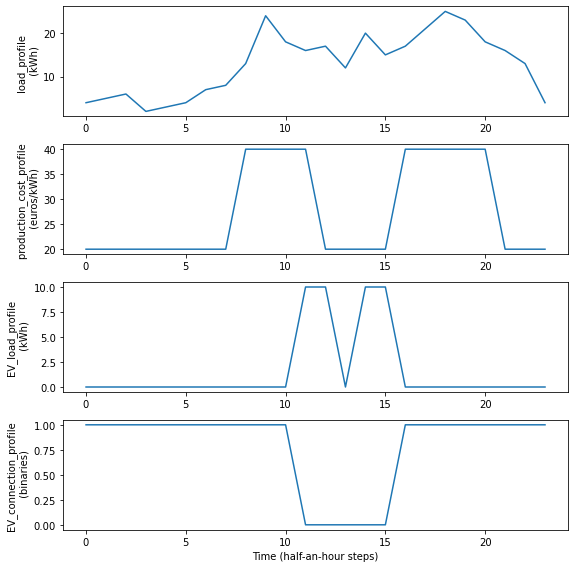

In [2]:
load_profile=[4, 5, 6, 2, 3, 4, 7, 8, 13, 24, 18, 16, 17, 12, 20, 15, 17,
                    21, 25, 23, 18, 16, 13, 4]
production_cost_profile=[20, 20, 20, 20, 20, 20, 20, 20, 40, 40, 40, 40, 20, 20, 20, 20, 40,
                               40, 40, 40, 40, 20, 20, 20]
EV_load_profile=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 0, 10, 10, 0,
                       0, 0, 0, 0, 0, 0, 0]
EV_connection_profile=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
                                1, 1, 1, 1, 1, 1, 1]

fig, axs = subplots(4, 1, figsize=(8,8))
axs[0].plot(load_profile)
axs[0].set_ylabel('load_profile \n (kWh)')
axs[1].plot(production_cost_profile)
axs[1].set_ylabel('production_cost_profile \n (euros/kWh)')
axs[2].plot(EV_load_profile)
axs[2].set_ylabel('EV_load_profile \n (kWh)')
axs[3].plot(EV_connection_profile)
axs[3].set_ylabel('EV_connection_profile \n (binaries)')
axs[3].set_xlabel('Time (half-an-hour steps)')
fig.tight_layout()
plt.show()


EV_capacity=50
EV_pcharge_max=20
EV_pdischarge_max=20

## 4) Modelling method

The case study is modelled with OMEGAlpes. OMEGAlpes is modelling tool based on the mixed-integer mathematical programming (MILP) formalism. Several references can be listed:
- General information: https://openenergy-platform.org/factsheets/models/198/. 
- Reference scientific publication : S. Hodencq, M. Brugeron, J. Fitó, L. Morriet, B. Delinchant, et F. Wurtz, « OMEGAlpes, an Open-Source Optimisation Model Generation Tool to Support Energy Stakeholders at District Scale », Energies, vol. 14, no 18, p. 5928, sept. 2021, doi: 10.3390/en14185928.
- Source code : https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes


### Model assumptions
The real life problem is supposed to be perfectly described by the MILP (or LP) problem built with OMEGAlpes. This problem describes dynamically energy quantities over one day, with one-hour time steps. The only economic quantity is the time-varying production cost (or the price of the electricity imported if considered as the electrical network). 
- Each energy node represents an energy balance equation applied at each time step (energy in = energy out). 
- The amount of the electricity produced from the "production" is unlimited at each time step.
- The "consumption" and the "EV_consumption" are supposed to be perfectly known in advance, as the production cost and the vehicle connection profile. 
- The state of charge of the battery must be equal at the beginning and at the end of the period

The detailed formulation of the problem can be found by looking at the OMEGAlpes source code and/or looking at the lp file generated by OMEGAlpes.


## 5) Modelling process with OMEGAlpes

### 5.1) Creating units


In [3]:
# Time configuration : 24 periods of one hour (1 day)
time = TimeUnit(periods=24, dt=1)  

# Create the load - The load profile is known
load = FixedConsumptionUnit(time, 'load', p=load_profile)

# Create the production unit - (One optimization variable for each time step)
production = VariableProductionUnit(time, 'production',
                                    operating_cost=production_cost_profile)

# Add an objective
production.minimize_operating_cost()

# Create the EV storage
EV_storage = StorageUnit(time, name='EV_storage', pc_max=EV_pcharge_max,
                         pd_max=EV_pdischarge_max, capacity=EV_capacity, ef_is_e0=True)

# Create the EV load - The load profile is known
EV_load = FixedConsumptionUnit(time, 'EV_load', p=EV_load_profile)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-01 23:00:00
Creating the load.
Creating the production.
Creating the EV_storage_discharge.
Creating the EV_storage_charge.
Creating the EV_storage.
Creating the EV_load.


### 5.2) Connecting units through nodes:

In [4]:
# Create the energy nodes and connect units
main_node = EnergyNode(time, 'main_node')
EV_node = EnergyNode(time, 'EV_node')

main_node.connect_units(load, production)
EV_node.connect_units(EV_load, EV_storage)

# Connect both nodes, including the availability of the EV 
# (the import and export capacities are set to zero if the vehicle is disconnected)
EV_node.export_to_node(main_node,
                       export_max=[EV_pdischarge_max if i == 1 else 0 for i in EV_connection_profile])
EV_node.import_from_node(main_node,
                         import_max=[EV_pcharge_max if i == 1 else 0 for i in EV_connection_profile])


# Checking the consistency of the EV load and disconnection profiles (optional)
unconsistentTimeSteps = []
for t in range(time.LEN):
    if EV_connection_profile[t] == 1 and EV_load_profile[t] != 0:
        unconsistentTimeSteps.append(t)
    if EV_load_profile[t] > EV_pdischarge_max:
        raise ValueError('The EV load profile exceeds the discharging capacity '
                         'at time step {}.'.format(t))
if len(unconsistentTimeSteps) > 0:
    warnings.warn("The load and the disconnection profiles of the EV may be unconsistent. "
                  "The vehicle is used while connected at time steps {}.".format(unconsistentTimeSteps))


Creating the main_node.
Creating the EV_node.


### 5.3)  Creating the model and solving

In [5]:
## Creating an empty model
model = OptimisationModel(time=time, name='electric_vehicle')

# Add nodes to the model
model.add_nodes(main_node, EV_node)

## Creating an .lp file in which the model is described for the solver
model.writeLP('electric_vehicle.lp')
model.solve_and_update()




--- Adding all variables to the model ---
Adding variable : main_node_energy_export_to_EV_node
Adding variable : main_node_is_exporting_to_EV_node
Adding variable : load_p
Adding variable : load_e_tot
Adding variable : production_p
Adding variable : production_e_tot
Adding variable : production_u
Adding variable : production_operating_cost
Adding variable : EV_node_energy_export_to_main_node
Adding variable : EV_node_is_exporting_to_main_node
Adding variable : EV_load_p
Adding variable : EV_load_e_tot
Adding variable : EV_storage_charge_p
Adding variable : EV_storage_charge_e_tot
Adding variable : EV_storage_charge_u
Adding variable : EV_storage_discharge_p
Adding variable : EV_storage_discharge_e_tot
Adding variable : EV_storage_discharge_u
Adding variable : EV_storage_capacity
Adding variable : EV_storage_e
Adding variable : EV_storage_u
Adding variable : EV_storage_p
Adding variable : EV_storage_e_tot
Adding variable : EV_storage_pc_max
Adding variable : EV_storage_pd_max
Adding va

/opt/conda/lib/python3.9/site-packages/omegalpes/general/optimisation/model.py:573: UserWarning: The unit main_node seems to have as parent set_export_min_EV_node_min which was not declared as parent.
  warnings.warn('The unit {} seems to have as parent {} '
/opt/conda/lib/python3.9/site-packages/omegalpes/general/optimisation/model.py:573: UserWarning: The unit EV_node seems to have as parent set_export_min_main_node_min which was not declared as parent.
  warnings.warn('The unit {} seems to have as parent {} '


## 6) Results:


 - - - - - OPTIMISATION RESULTS - - - - - 

 Note for OMEGAlpes node graphs: bars are productions and dots are consumptions

Preparing to plot the energy flows through the node main_node.
	Add power from load.
	Add power from production.
	Add power from EV_node.
	Add power from main_node.

Preparing to plot the energy flows through the node EV_node.
	Add power from EV_load.
	Add power from EV_storage_charge.
	Add power from EV_storage_discharge.
	Add power from EV_node.
	Add power from main_node.


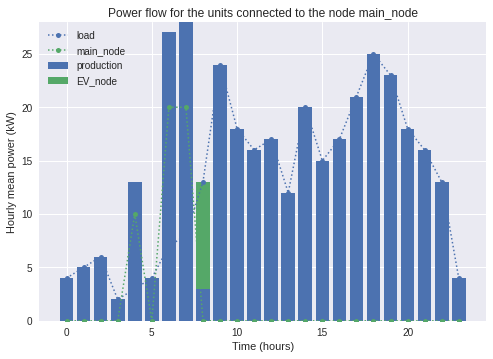

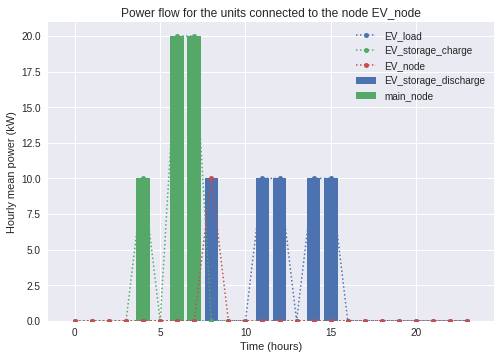

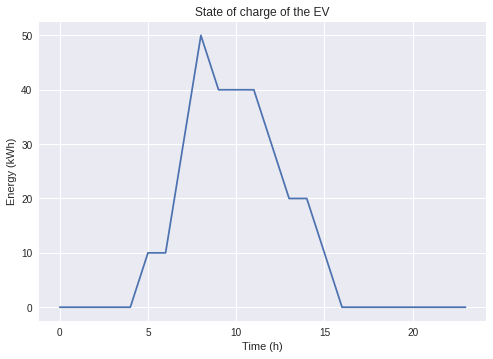

In [6]:
    if LpStatus[model.status] == 'Optimal':
        print("\n - - - - - OPTIMISATION RESULTS - - - - - ")
        
        print("\n Note for OMEGAlpes node graphs: bars are productions and dots are consumptions")

        # Show the graph
        # Power curves
        plot_node_energetic_flows(main_node)
        plot_node_energetic_flows(EV_node)

        # SOC curve
        plot_quantity(time, EV_storage.e)
        plt.xlabel('Time (h)')
        plt.ylabel('Energy (kWh)')
        plt.title('State of charge of the EV')
        plt.show()

    elif LpStatus[model.status] == 'Infeasible':
        print("Sorry, the optimisation problem has no feasible solution !")

    elif LpStatus[model.status] == 'Unbounded':
        print("The cost function of the optimisation problem is unbounded !")

    elif LpStatus[model.status] == 'Undefined':
        print("Sorry, a feasible solution has not been found (but may exist). "
              "PuLP does not manage to interpret the solver's output, "
              "the infeasibility of the MILP problem may have been "
              "detected during presolve.")

    else:
        print("Sorry, the optimisation problem has not been solved.")

### Additional indicators:

In [7]:
print('Total consumption of the "consumption" module = {0} kWh.'.format(load.e_tot))
print('Total consumption of the "EV_consumption" module) = {0} kWh.'.format(EV_load.e_tot))
print('Total production of the "production" module) = {0} kWh.'.format(production.e_tot))

Total consumption of the "consumption" module = 311.0 kWh.
Total consumption of the "EV_consumption" module) = 40.0 kWh.
Total production of the "production" module) = 351.0 kWh.


<a id='factsheet'></a>
## Factsheet
Notebook factsheet based on the [OEP scenario factsheet](https://openenergy-platform.org/factsheets/scenarios/)


<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid #CCC;
	}
	.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>
<table class="tableizer-table">
 <tr><td rowspan=21>Study</td>
 <tr><td>&nbsp;</td><td>Name</td><td>Electric vehicle model : an OMEGAlpes example</td></tr>
 <tr><td>&nbsp;</td><td>Author - institution</td><td>Etienne Cuisinier - G2Elab</td></tr>
 <tr><td>&nbsp;</td><td>Contact</td><td>etienne.cuisinier@g2elab.grenoble-inp.fr</td></tr>
 <tr><td>&nbsp;</td><td>Client</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Funding</td><td>Public</td></tr>
 <tr><td>&nbsp;</td><td>Aim</td><td>This example shows how to model an electric vehicle with OMEGAlpes to study its interaction with another energy system</td></tr>
 <tr><td>&nbsp;</td><td>New aspects</td><td></td></tr>
 <tr><td>&nbsp;</td><td>Tools</td><td>OMEGAlpes</td></tr>
 <tr><td>&nbsp;</td><td>Modeled energy sectors</td><td>Electricity</td></tr>
 <tr><td>&nbsp;</td><td>Economic (behavioural) rationale </td><td>Single fictive decision-maker with perfect knowledge (perfect foresight optimization)</td></tr>
 <tr><td>&nbsp;</td><td>Technologies included </td><td>An electric vehicle</td></tr>
 <tr><td>&nbsp;</td><td>Economic focuses included</td><td>Yes</td></tr>
 <tr><td>&nbsp;</td><td>Social focuses included</td><td>No</td></tr>
 <tr><td>&nbsp;</td><td>Endogenous variables</td><td>Production power, power exchanges of the batteries of the electric vehicle</td></tr>
 <tr><td>&nbsp;</td><td>Time steps</td><td>One-hour</td></tr>
 <tr><td rowspan=7>Empirical data</td>
 <tr><td>Endogenous time series used</td><td>Electric consumption of the main node (a building), production costs, electric consumption of the electric vehicle, connection profile of the electric vehicle</td></tr>
 <tr><td>Technical data + usage</td><td>Capacity, maximum charge and discharge power of the electric vehicle battery</td></tr>
 <tr><td>Social data</td><td>None</td></tr>
 <tr><td>Economical data</td><td>Time varying production costs (i.e. grid prices)</td></tr>
 <tr><td>&nbsp;</td><td>Ecological data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Pre-Processing</td><td>None</td></tr>
 <tr><td rowspan=5>Assumptions</td>
<tr><td>&nbsp;</td><td>Energy assumption</td><td>See Section 3</td></tr>
 <tr><td>&nbsp;</td><td>Environmental assumptions</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Economic assumption</td><td>See Section 3</td></tr> 
 <tr><td>&nbsp;</td><td>Post-processing</td><td>None</td></tr> 
 <tr><td rowspan=5>Results</td>
 <tr><td>&nbsp;</td><td>Uncertainty assesment</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Robustness</td><td>MILP optimizations lead with OMEGAlpes are robust and reproducible. If any issue is met with this tool, please indicate them in the Issues section of their gitlab.</td></tr>
 <tr><td>&nbsp;</td><td>Comparability / Validation</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Conclusions</td><td>OMEGAlpes can be used to model an electric vehicle and its interaction with an existing energy system</td></tr>
</tbody></table>